In [79]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

In [80]:
# Cargar el dataset
df = pd.read_csv('StudentPerformanceFactors.csv')


# Definición del Problema

El objetivo principal de este proyecto es predecir el rendimiento académico de los estudiantes utilizando un modelo de Machine Learning. Para lograr esto, trabajaremos con un dataset que contiene diversas características que podrían influir en el puntaje final de los estudiantes en sus exámenes. La variable objetivo será **`Exam_Score`**, mientras que el resto de las variables serán los factores que podrían influir en dicho rendimiento.

## Contexto del Problema

El rendimiento académico de los estudiantes está influenciado por múltiples factores, incluyendo aspectos personales, socioeconómicos y académicos. Este estudio busca identificar qué factores tienen mayor impacto en el resultado de los estudiantes, con el objetivo de ayudar a diseñar estrategias para mejorar su desempeño.

## Objetivo Específico

El objetivo específico es construir un modelo predictivo que pueda estimar el puntaje de un estudiante basándose en características como horas de estudio, nivel de motivación, horas de sueño, calidad del profesor, y muchos otros factores registrados en el dataset.

## Variables Importantes

Algunas de las variables más importantes para el análisis son:

- **Hours_Studied**: Cantidad de horas de estudio.
- **Attendance**: Porcentaje de asistencia a clases.
- **Parental_Involvement**: Nivel de involucramiento de los padres.
- **Sleep_Hours**: Promedio de horas de sueño por día.
- **Motivation_Level**: Nivel de motivación del estudiante.

## Pregunta de Investigación

- ¿Cuáles son los factores más influyentes en el rendimiento académico de los estudiantes?
- ¿Es posible predecir el puntaje de un estudiante utilizando variables de contexto y comportamiento?

## Enfoque

Para abordar este problema, primero realizaremos un análisis exploratorio de los datos para entender mejor la distribución y las relaciones entre las diferentes variables. Luego, seguiremos con la preparación de los datos, incluyendo la limpieza y transformación necesarias para aplicar técnicas de Machine Learning que nos permitan hacer una predicción precisa.



# Preparación de Datos

En esta etapa nos enfocaremos en la limpieza y transformación del dataset para asegurar que esté en condiciones adecuadas para el modelado. La calidad de los datos es crucial para garantizar un buen rendimiento de los modelos de Machine Learning.

## 1. Tratamiento de Valores Nulos

En la etapa anterior, identificamos que hay tres columnas con valores nulos:
- **Teacher_Quality** (78 valores faltantes)
- **Parental_Education_Level** (90 valores faltantes)
- **Distance_from_Home** (67 valores faltantes)

### Estrategia para el Tratamiento

- Para **Teacher_Quality**, podríamos imputar los valores faltantes utilizando la moda, ya que se trata de una variable categórica y la mayoría de los valores presentes son \"Medium\".
- Para **Parental_Education_Level**, también se podría imputar con la moda, ya que representa niveles educativos y la categoría más frecuente es \"High School\".
- Para **Distance_from_Home**, que también es categórica, podríamos seguir un enfoque similar y llenar los valores faltantes con la moda.

## 2. Codificación de Variables Categóricas

El dataset contiene varias variables categóricas, como **Internet_Access**, **Motivation_Level**, y **Family_Income**. Estas variables deben ser transformadas a un formato numérico para ser utilizadas por los algoritmos de Machine Learning.

- Utilizaremos **One-Hot Encoding** para variables como **School_Type** y **Parental_Involvement**, ya que no tienen un orden implícito.
- Para variables como **Motivation_Level**, que tienen un orden (bajo, medio, alto), se utilizará **Label Encoding**.

## 3. Escalado de Variables Numéricas

Las variables numéricas, como **Hours_Studied** y **Attendance**, tienen diferentes rangos de valores. Para mejorar el rendimiento de algunos algoritmos, es recomendable escalar estas variables.

- Utilizaremos **Min-Max Scaling** para escalar las variables entre 0 y 1, asegurando que todas las características tengan la misma importancia durante el proceso de modelado.

## 4. Balanceo de Clases

Al analizar la distribución de algunas variables categóricas, notamos que están claramente dominadas por una categoría. Si este fuera el caso para la variable objetivo, sería necesario aplicar técnicas de **resampling** para balancear las clases. Verificaremos el balance de **Exam_Score** y, si es necesario, utilizaremos técnicas como **SMOTE** o **undersampling** para mejorar el equilibrio.

## 5. Conclusión de la Preparación de Datos

Con la preparación de los datos completada, nos aseguramos de que nuestro dataset esté listo para ser utilizado en el proceso de modelado. Hemos tratado los valores nulos, codificado las variables categóricas y escalado las variables numéricas para mejorar la eficacia de los algoritmos de Machine Learning.


In [82]:
def preprocess_data(df):
    # Verificar si las columnas 'Family_Income' y 'Exam_Score' existen
    if 'Family_Income' not in df.columns:
        raise KeyError("La columna 'Family_Income' no se encuentra en el dataset.")
    if 'Exam_Score' not in df.columns:
        raise KeyError("La columna 'Exam_Score' no se encuentra en el dataset.")
    
    # Mapeo para Family_Income
    income_mapping = {'Bajo': 1, 'Medio': 2, 'Alto': 3}
    df['Family_Income'] = df['Family_Income'].map(income_mapping)
    
    # Imputar valores faltantes en Family_Income con la moda (valor más frecuente) o con un valor predeterminado
    if df['Family_Income'].isnull().any():
        # Intentar imputar con la moda; si no hay moda, usar un valor predeterminado de 2 (Medio)
        family_income_mode = df['Family_Income'].mode()
        if family_income_mode.empty:
            df['Family_Income'] = df['Family_Income'].fillna(2)  # Usar 2 como valor predeterminado
        else:
            df['Family_Income'] = df['Family_Income'].fillna(family_income_mode[0])

    # Variables categóricas restantes para convertir en dummies
    categorical_columns = [
        'Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 
        'Motivation_Level', 'Internet_Access', 'Teacher_Quality', 'School_Type', 
        'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 
        'Distance_from_Home', 'Gender'
    ]
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

    # Crear la columna Low_Performance basada en el valor de Exam_Score
    df['Low_Performance'] = df['Exam_Score'].apply(lambda x: 1 if x < 70 else 0)

    return df


In [83]:
df_clean = preprocess_data(df)


In [84]:
def balance_data(df):
    # Verificar valores de Low_Performance
    if 'Low_Performance' not in df.columns:
        raise KeyError("La columna 'Low_Performance' no se encuentra en el dataframe.")

    print(df['Low_Performance'].value_counts(dropna=False))  # Verificar que no haya valores NaN

    # Separar características (X) y objetivo (y)
    X = df.drop(columns=['Exam_Score', 'Low_Performance'])
    y = df['Low_Performance']

    # Combinar X e y para el remuestreo
    data_combined = pd.concat([X, y], axis=1)

    # Separar clases mayoritaria y minoritaria
    # La función crea dos subconjuntos de datos: uno para la clase mayoritaria (Low_Performance=0) y otro para la clase minoritaria (Low_Performance=1).
    # Estos subconjuntos permiten identificar la cantidad de ejemplos en cada clase, lo cual es necesario para saber cuánto se necesita balancear.
    majority = data_combined[data_combined['Low_Performance'] == 0]
    minority = data_combined[data_combined['Low_Performance'] == 1]

    # Sobremuestreo de la clase minoritaria (sólo en entrenamiento)
    minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=22)

    # Combinar clases
    data_balanced = pd.concat([majority, minority_upsampled])

    # Actualizar X y y
    X = data_balanced.drop('Low_Performance', axis=1)
    y = data_balanced['Low_Performance']

    return X, y

In [86]:
df_clean = preprocess_data(df)

X, y = balance_data(df_clean)


Low_Performance
1    4982
0    1625
Name: count, dtype: int64



### Interpretación:

Esto significa que los datos están desbalanceados: la clase 1 (bajo rendimiento) tiene muchos más ejemplos que la clase 0 (rendimiento normal o alto). En este caso, aproximadamente el 75% de los datos corresponde a la clase 1, mientras que solo el 25% corresponde a la clase 0

# Modelado y Evaluación

En esta sección, entrenaremos varios modelos de Machine Learning para predecir el rendimiento académico de los estudiantes. El enfoque será un problema de clasificación binaria, donde la variable objetivo (`Low_Performance`) indica si el estudiante tiene un rendimiento bajo (1) o no (0).


### División de Datos para Entrenamiento y Prueba

Para evaluar el rendimiento de los modelos, dividimos el dataset en conjuntos de entrenamiento y prueba. Utilizaremos un `test_size` del 20% para el conjunto de prueba y el 80% restante para el entrenamiento. La semilla `random_state=22` asegura que los resultados sean reproducibles.

Explicar random_state


In [87]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)


## Entrenamiento y Evaluación de Modelos

A continuación, entrenaremos varios modelos para evaluar cuál tiene mejor desempeño en predecir la variable objetivo `Low_Performance`. Utilizaremos:
- **HistGradientBoostingClassifier**: Un modelo basado en boosting de histogramas, efectivo en problemas con características categóricas.
- **RandomForestClassifier**: Un modelo de ensamble que combina múltiples árboles de decisión para mejorar la precisión.
- **Logistic Regression**: Un modelo lineal, útil para interpretar la relación entre las variables.
- **SVM (Support Vector Machine)**: Un modelo robusto en datasets pequeños y de alta dimensionalidad.

Cada modelo se evaluará utilizando la precisión y se generarán matrices de confusión para analizar los errores de clasificación.


HistGradientBoostingClassifier Precisión del modelo: 0.92
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       309
           1       0.93      0.91      0.92       341

    accuracy                           0.92       650
   macro avg       0.92      0.92      0.92       650
weighted avg       0.92      0.92      0.92       650


Random Forest Precisión del modelo: 0.91
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       309
           1       0.94      0.89      0.91       341

    accuracy                           0.91       650
   macro avg       0.91      0.91      0.91       650
weighted avg       0.91      0.91      0.91       650



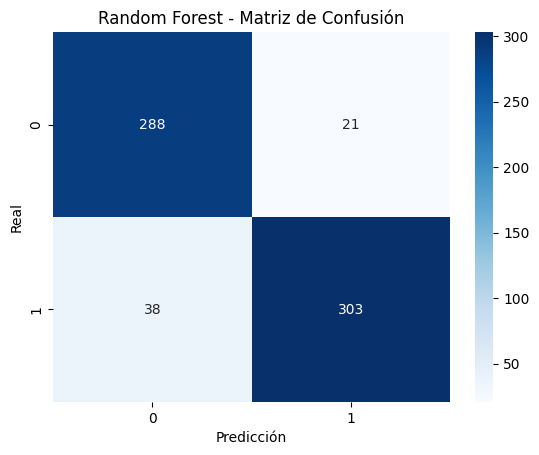


Regresión Logística Precisión del modelo: 0.95
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       309
           1       0.96      0.94      0.95       341

    accuracy                           0.95       650
   macro avg       0.95      0.95      0.95       650
weighted avg       0.95      0.95      0.95       650



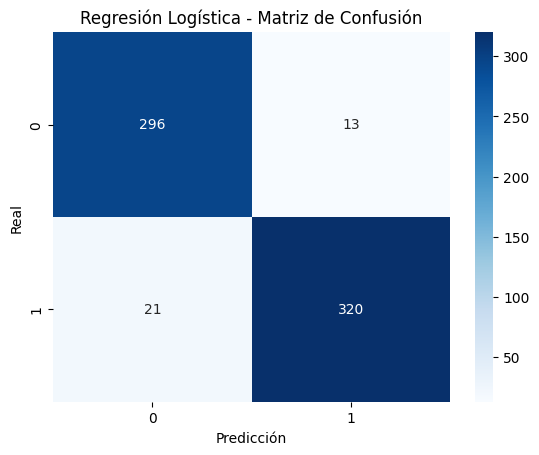

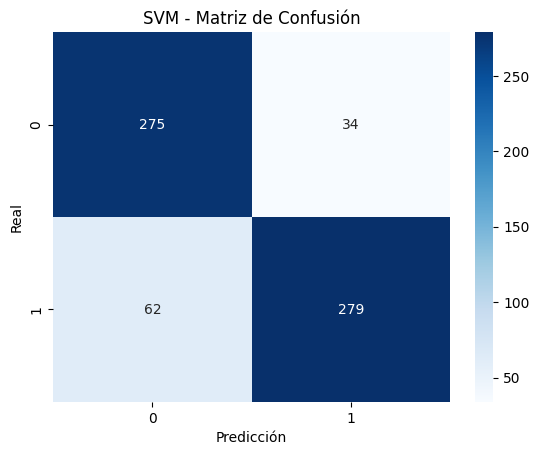

In [88]:
# Entrenar y evaluar modelos
def train_models(X_train, y_train, X_test, y_test):
    # Crear y ajustar el modelo HistGradientBoostingClassifier
    hgb_model = HistGradientBoostingClassifier()
    hgb_model.fit(X_train, y_train)

    # Hacer predicciones y calcular precisión
    hgb_predictions = hgb_model.predict(X_test)
    hgb_accuracy = accuracy_score(y_test, hgb_predictions)
    print(f"HistGradientBoostingClassifier Precisión del modelo: {hgb_accuracy:.2f}")
    print(classification_report(y_test, hgb_predictions))

    # Random Forest Classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=22)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    print(f"\nRandom Forest Precisión del modelo: {accuracy_score(y_test, y_pred_rf):.2f}")
    print(classification_report(y_test, y_pred_rf))
    
    # Matriz de confusión para Random Forest
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Random Forest - Matriz de Confusión')
    plt.show()

    # Regresión Logística con pipeline de preprocesamiento
    lr_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(random_state=22))
    ])
    lr_pipeline.fit(X_train, y_train)
    lr_predictions = lr_pipeline.predict(X_test)
    lr_accuracy = accuracy_score(y_test, lr_predictions)
    print(f"\nRegresión Logística Precisión del modelo: {lr_accuracy:.2f}")
    print(classification_report(y_test, lr_predictions))

    # Matriz de confusión para Regresión Logística
    cm_lr = confusion_matrix(y_test, lr_predictions)
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Regresión Logística - Matriz de Confusión')
    plt.show()

    # SVM (Support Vector Machine) con imputación de datos faltantes
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    svm_model = SVC()
    svm_model.fit(X_train_imputed, y_train)
    svm_predictions = svm_model.predict(X_test_imputed)

    # Matriz de confusión para SVM
    cm_svm = confusion_matrix(y_test, svm_predictions)
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('SVM - Matriz de Confusión')
    plt.show()

# Llamar a la función sin espacios en los nombres de las variables
train_models(X_train, y_train, X_test, y_test)


## Análisis de Importancia de las Variables

Finalmente, utilizaremos el modelo de **Random Forest** para analizar la importancia de cada variable. Esto nos permitirá identificar cuáles son los factores más influyentes en el rendimiento académico de los estudiantes.


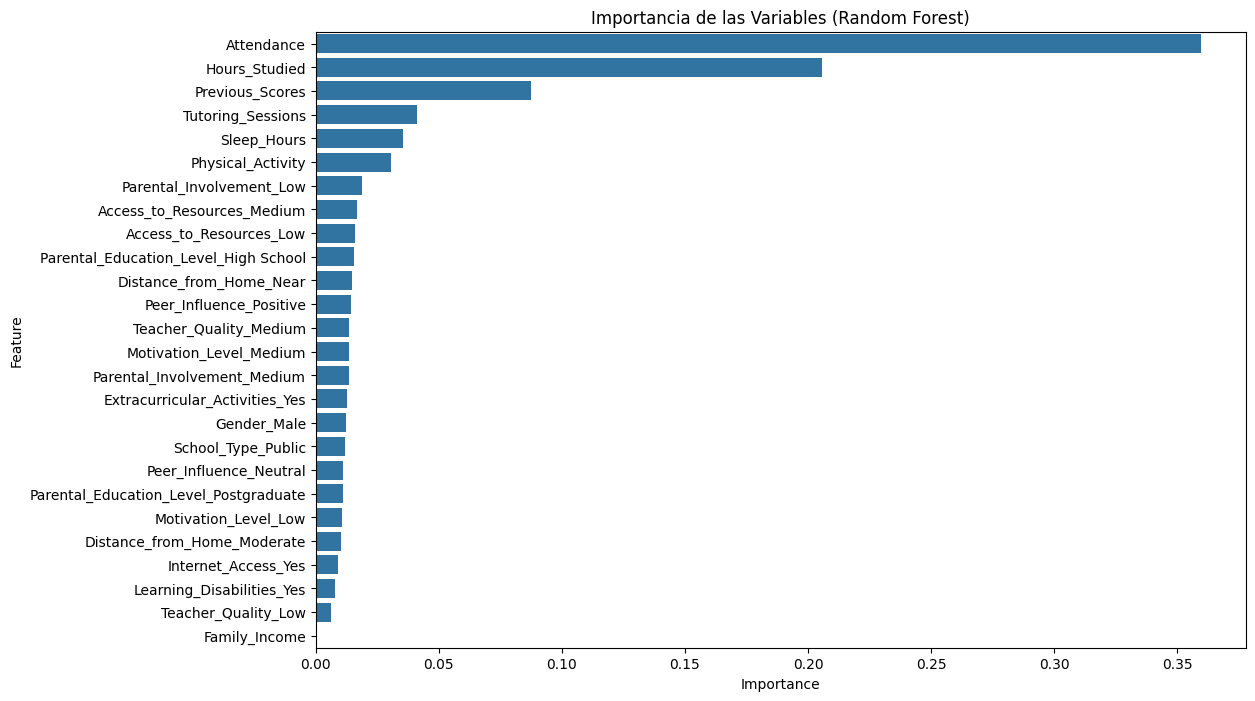

In [89]:
# Visualizar importancia de características
def feature_importance(model, X):
    importances = model.feature_importances_
    features = X.columns
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    
    # Visualizar importancias de variables
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Importancia de las Variables (Random Forest)')
    plt.show()

# Entrenar el modelo Random Forest para importancia de variables
rf_model = RandomForestClassifier(n_estimators=100, random_state=22)
rf_model.fit(X_train, y_train)

# Llamar a la función
feature_importance(rf_model, X)


## Resumen de la Sección de Modelado y Evaluación

Probamos varios modelos de clasificación para predecir el rendimiento académico de los estudiantes y evaluamos su precisión. Las matrices de confusión y los reportes de clasificación nos permiten analizar el rendimiento de cada modelo en detalle. Además, utilizamos el modelo de Random Forest para calcular la importancia de las variables, lo cual nos proporciona información valiosa sobre los factores más influyentes en el rendimiento académico.
